In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Leer Data

In [2]:
data = pd.read_csv("credit_risk_dataset.csv")
data

FileNotFoundError: [Errno 2] No such file or directory: 'credit_risk_dataset.csv'

Ver datos nulos

In [ ]:
data.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

Eliminar datos nulos

In [ ]:
data.dropna(inplace=True)

Gráficos de dispersión

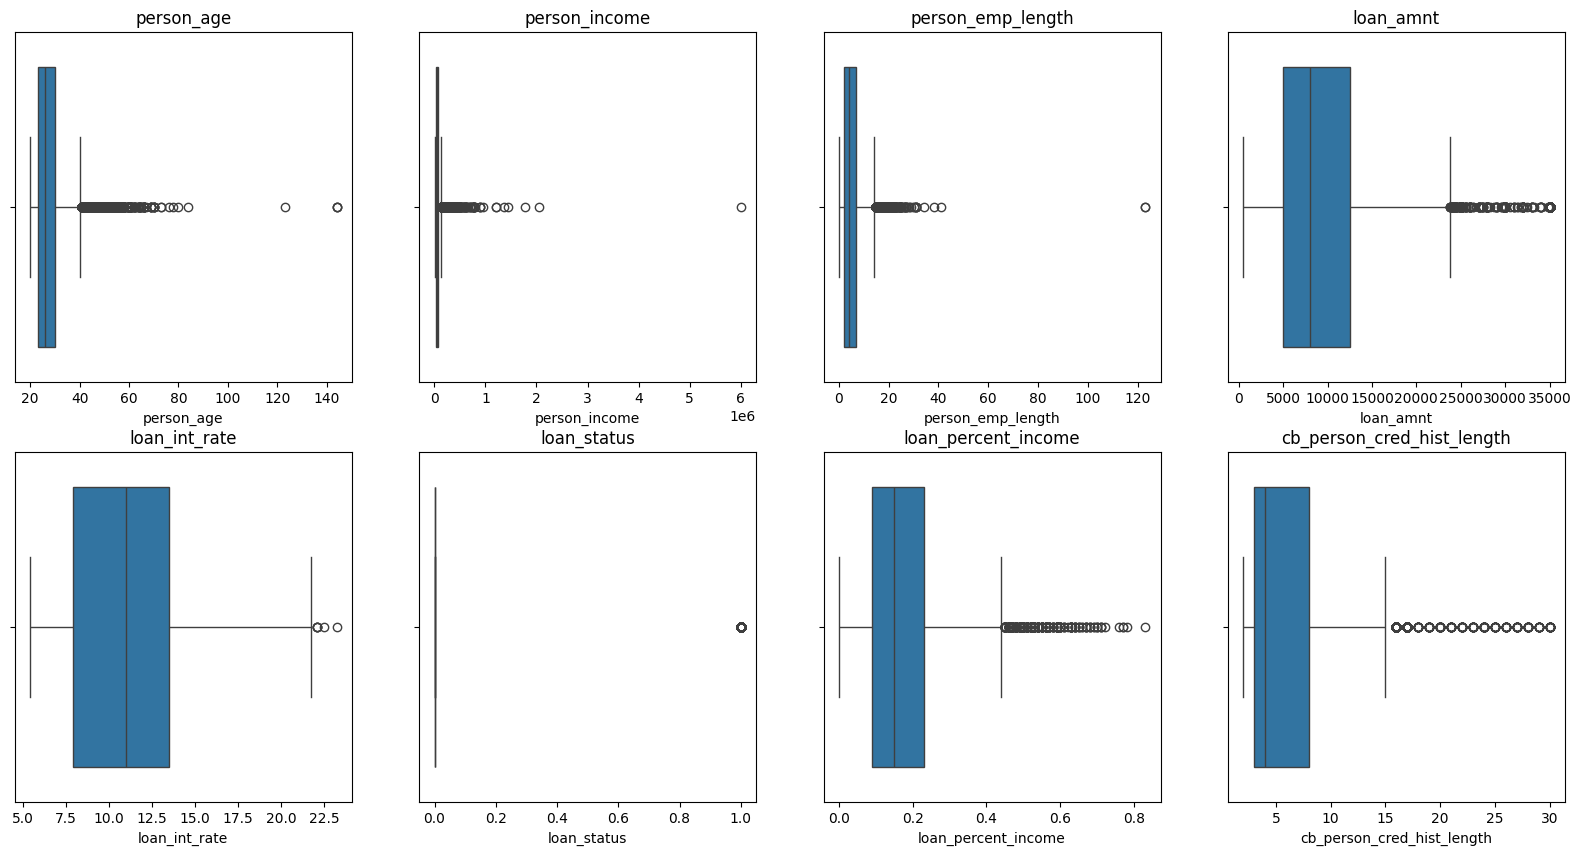

In [ ]:
col_numericas = data.select_dtypes(include='number').columns.tolist() #Queremos sólo las columnas numéricas

plt.figure(figsize=(20, 10))

for i in range(len(col_numericas)):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(x=data[col_numericas[i]])
    plt.title(col_numericas[i])
plt.show()

Eliminar valores atípicos

In [ ]:
#Filtrar data
def iqr(data, column): #Definir función
    q3 = data[column].quantile(0.75) #3er cuartil
    q1 = data[column].quantile(0.25) #1er cuartil
    superior_limit = q3 + 1.5*(q3 - q1)
    inferior_limit = q1 - 1.5*(q3 - q1)
    return data[(data[column] < superior_limit) & (data[column] > inferior_limit)]

In [ ]:
#Filtrar data solo a columnas numéricas
for col in ["person_age","person_income","person_emp_length","loan_amnt","loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length"]:
    data = iqr(data, col) 

Gráficos de dispersión después de eliminar outliers

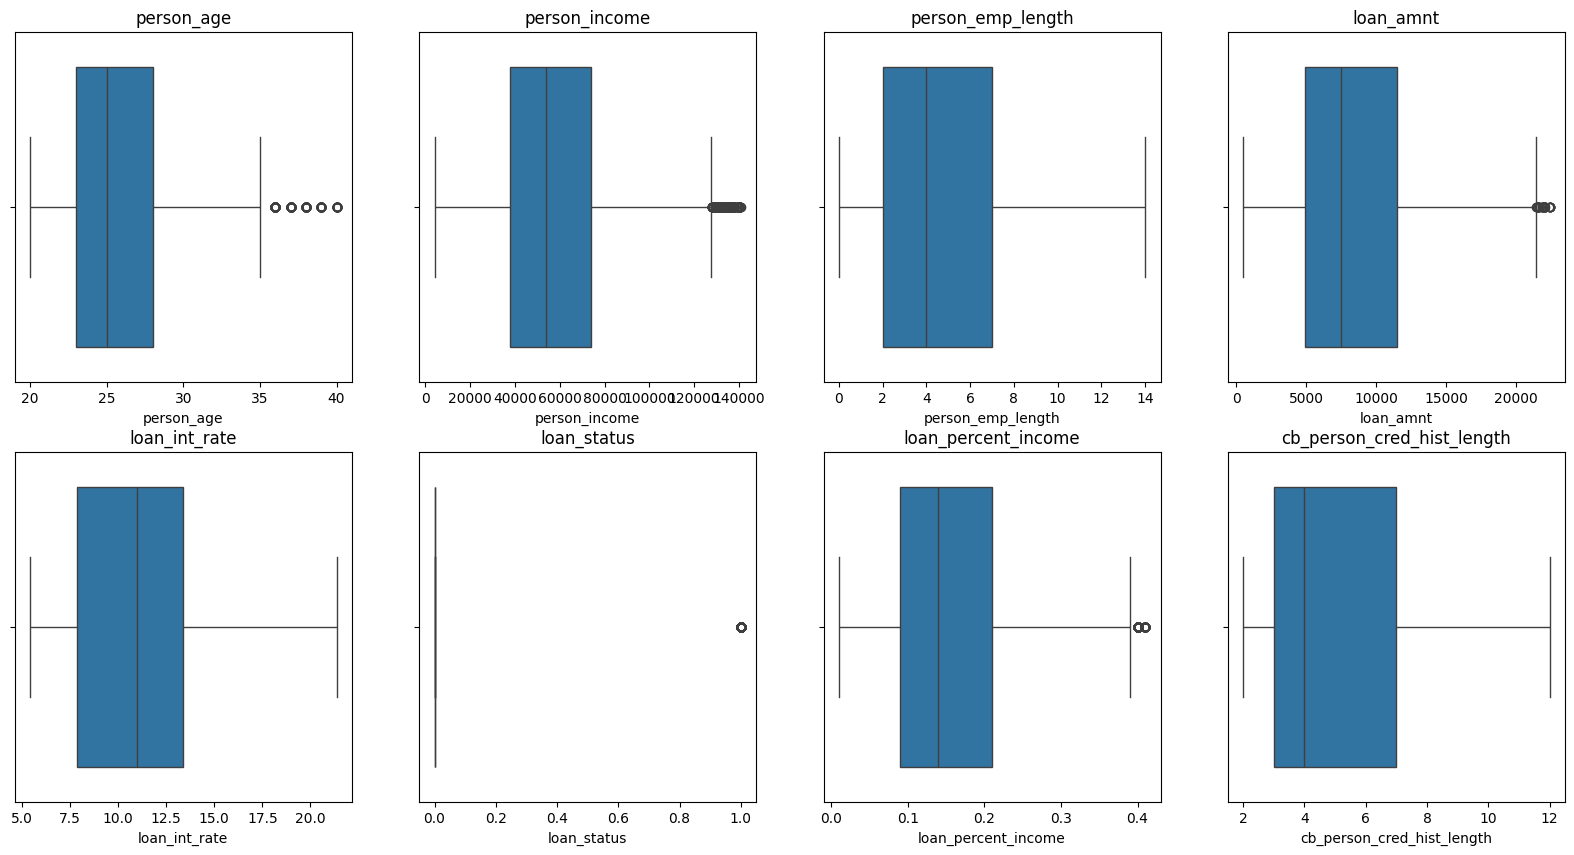

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(len(col_numericas)):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(x=data[col_numericas[i]])
    plt.title(col_numericas[i])
plt.show()

Pasar variables categóricas a numéricas

In [ ]:
from sklearn.preprocessing import LabelEncoder #Llamamos la librería

VC = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"] #Variables categóricas
LE = LabelEncoder() #Creamos LabelEncoder
for i in VC: #Aplicamos LabelEncoder a las variables categóricas
    data[i] = LE.fit_transform(data[i])

Matriz de correlación

In [ ]:
CM = data.corr() #Calcular la matriz de correlación

#Gráfico de la matriz 
plt.figure(figsize=(6, 5))
sns.heatmap(CM, cmap='coolwarm', center=0)
plt.title("Mapa de calor de correlación")
plt.show()

Gráfico de balance de clases

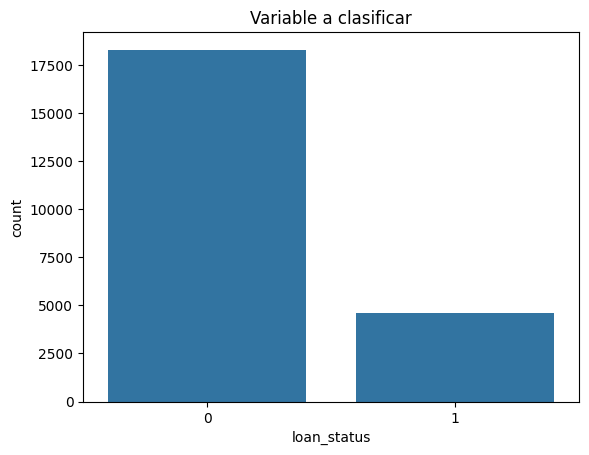

In [ ]:
sns.countplot(x = 'loan_status', data = data)
plt.title('Variable a clasificar')
plt.show()
#Hay un desbalance presente indicando que hay mas estados de prestamos pagados que no pagados

Separar variable x e y

In [ ]:
X = data.drop('loan_status', axis=1) #Variables independientes
y = data['loan_status'] #Variable dependiente

Separamos datos en entrenamiento y testeo

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #80% entrenamiento Y 20% testeo

# Modelo Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Crear modelo Random Forest
modeloRF = RandomForestClassifier(
    n_estimators=50, #50 arboles
    max_depth=20, #Profundidad de 20
    min_samples_leaf=80, #Minimo de 80 muestra por hoja
    class_weight='balanced', #Se balancean las clases
    random_state=42
)

Entrenar modelo

In [ ]:
# Entrenar el modelo
modeloRF.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=80, n_estimators=50, random_state=42)

Métricas de desempeño con validación cruzada

In [ ]:
from sklearn.model_selection import cross_val_predict #Validación cruzada
from sklearn.metrics import classification_report #Metricas de clasificación

# Predicciones con validación cruzada
y_pred = cross_val_predict(modeloRF, X, y, cv=10) #Validación cruzada con 10 folds

# Métricas de clasificación
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.85      0.89     18300
           1       0.55      0.74      0.63      4584

    accuracy                           0.83     22884
   macro avg       0.74      0.80      0.76     22884
weighted avg       0.85      0.83      0.84     22884



## Análisis de Overfitting

Curva de aprendizaje

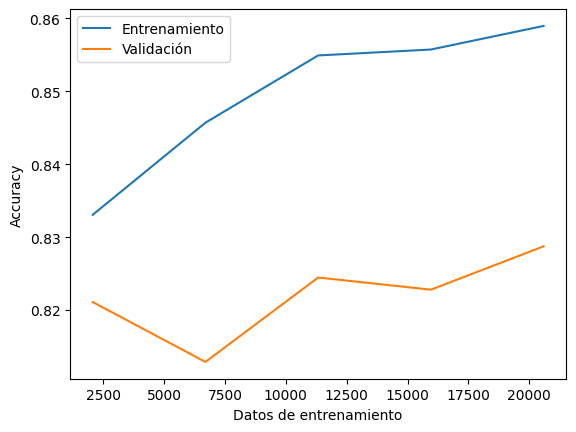

In [ ]:
from sklearn.model_selection import learning_curve #Llamamos la librería
train_sizes, train_scores, val_scores = learning_curve(modeloRF, X, y, cv=10, scoring="accuracy")

plt.plot(train_sizes, train_scores.mean(axis=1), label="Entrenamiento")
plt.plot(train_sizes, val_scores.mean(axis=1), label="Validación")
plt.xlabel("Datos de entrenamiento")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Ver importancia de cada variable según random forest

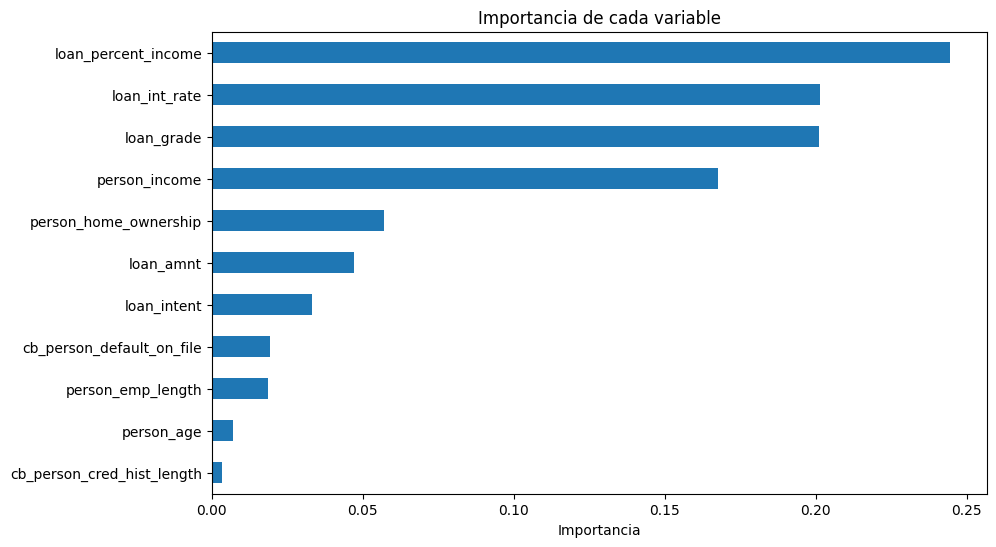

In [ ]:
#Ver la importancia de cada variable
importancia_variables = pd.Series(modeloRF.feature_importances_, index=X.columns) 
importancia_variables = importancia_variables.sort_values() # Ordenar de menor a mayor


#Gráfico
plt.figure(figsize=(10, 6))
importancia_variables.plot(kind="barh")
plt.title("Importancia de cada variable")
plt.xlabel("Importancia")
plt.show()

Matriz de confusión

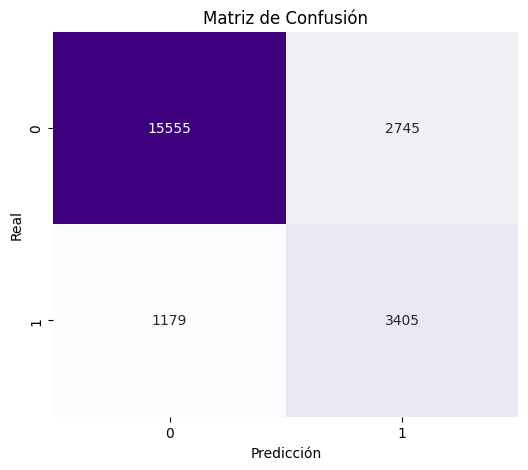

In [ ]:
from sklearn.metrics import confusion_matrix

# Creación de matriz de confusión
MC = confusion_matrix(y, y_pred) 

# Gráfico matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(MC, annot=True, fmt='g', cmap="Purples", cbar=False)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

Visualización de un árbol del modelo random forest

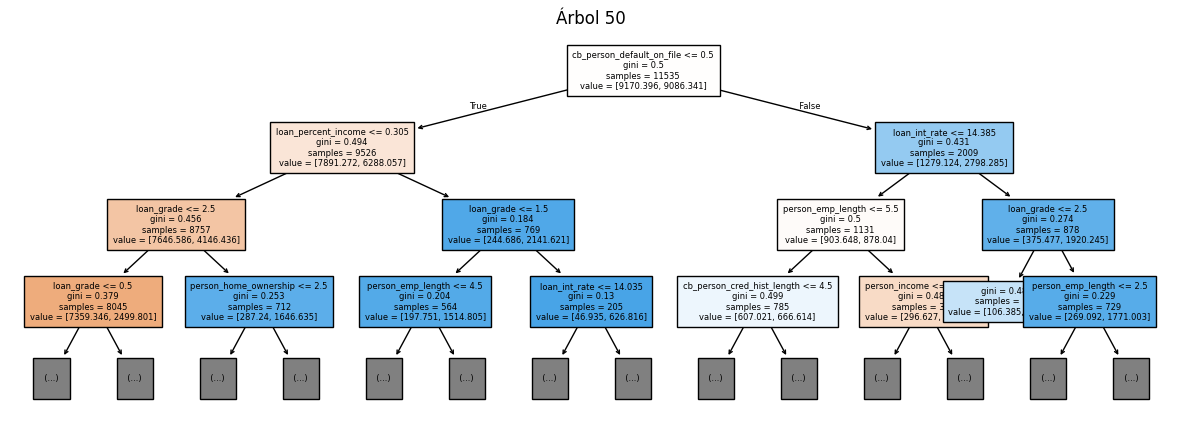

In [ ]:
from sklearn.tree import plot_tree

# Grafico del arbol 50, mostrando una profundidad de 3
plt.figure(figsize=(15, 5))
plot_tree(modeloRF.estimators_[49], feature_names=X.columns, filled=True, max_depth=3, fontsize=6) #Con profundidad de 3
plt.title("Árbol 50")
plt.show()